In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

## The task of credit scoring is being solved.
AUC (Area Under the Curve) was chosen as the evaluation metric.
### Target variable
**Delinquent90** – whether there were delays in credit payments of more than 90 days (binary) – available only in the training dataset

### Non-target features of bank clients:

**Age** – age (float)  
**Income** – monthly income (float)  
**BalanceToCreditLimit** – ratio of credit card balance to credit limit (float)  
**DIR** – Debt-to-Income Ratio (float)  
**NumLoans** – number of loans and credit lines  
**NumRealEstateLoans** – number of mortgages and real estate–related loans (integer)  
**NumDependents** – number of family members financially supported by the client, excluding the client (integer)  
**Num30-59Delinquencies** – number of payment delays between 30 and 59 days (integer)  
**Num60-89Delinquencies** – number of payment delays between 60 and 89 days (integer)  

In [2]:
train_df = pd.read_csv(r'C:\Users\_Lenovo_\PycharmProjects\jupyter_rabota\credit-scoring\credit_scoring_train.csv', index_col='client_id')
test_df = pd.read_csv(r'C:\Users\_Lenovo_\PycharmProjects\jupyter_rabota\credit-scoring\credit_scoring_test.csv', index_col='client_id')

In [3]:
X, y = train_df.drop('Delinquent90', axis=1), train_df['Delinquent90']

In [4]:
initial_shape_train = train_df.shape
initial_shape_train

(75000, 10)

In [5]:
train_df.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
client_id,,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0


In [6]:
initial_shape_test = test_df.shape
initial_shape_test

(75000, 9)

In [7]:
test_df.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
client_id,,,,,,,,,
75000,0.488558,39.2,7,2,2.0,0,0,2866.926559,0.369443
75001,0.132810,42.3,8,0,1.0,4,0,4303.412944,1.028329
75002,1784.812905,51.5,5,1,0.0,0,0,NaN,0.081461
75003,0.538571,57.1,30,2,0.0,0,0,7672.294930,0.485850
75004,0.098539,70.1,3,0,0.0,0,0,4507.010360,0.004258


In [8]:
# Check if the values in train and test columns are only numeric or None

display(train_df.dtypes.unique())
test_df.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

array([dtype('float64'), dtype('int64')], dtype=object)

In [9]:
isna_train = train_df.isna().any()
isna_train

DIR                      False
Age                      False
NumLoans                 False
NumRealEstateLoans       False
NumDependents             True
Num30-59Delinquencies    False
Num60-89Delinquencies    False
Income                    True
BalanceToCreditLimit     False
Delinquent90             False
dtype: bool

In [10]:
isna_test = test_df.isna().any()
isna_test

DIR                      False
Age                      False
NumLoans                 False
NumRealEstateLoans       False
NumDependents             True
Num30-59Delinquencies    False
Num60-89Delinquencies    False
Income                    True
BalanceToCreditLimit     False
dtype: bool

In [11]:
train_df[train_df.columns[isna_train]].isna().sum(), test_df[test_df.columns[isna_test]].isna().sum()

(NumDependents     1916
 Income           14847
 dtype: int64,
 NumDependents     2008
 Income           14884
 dtype: int64)

In [12]:
# We see that the values are too large in both cases, and the difference between the quartiles is much smaller than 
# the maximum values.

# Therefore, we will fill in the missing values with the median instead of the mean, so that outliers do not 
# affect our model.

display(train_df[train_df.columns[isna_train]].describe().round(2))
test_df[test_df.columns[isna_test]].describe().round(2)

,NumDependents,Income
count,73084.00,60153.00
mean,0.76,6740.06
std,1.11,14228.75
min,0.00,0.00
25%,0.00,3421.35
50%,0.00,5424.55
75%,1.00,8291.52
max,20.00,1805573.35


,NumDependents,Income
count,72992.00,60116.00
mean,0.76,6667.20
std,1.12,14706.89
min,0.00,0.00
25%,0.00,3410.79
50%,0.00,5421.11
75%,1.00,8271.53
max,10.00,3027514.21


In [13]:
X['NumDependents'].fillna(X['NumDependents'].median(), inplace=True)
X['Income'].fillna(X['Income'].median(), inplace=True)
test_df['NumDependents'].fillna(test_df['NumDependents'].median(), inplace=True)
test_df['Income'].fillna(test_df['Income'].median(), inplace=True)

array([69987,  5013], dtype=int64)

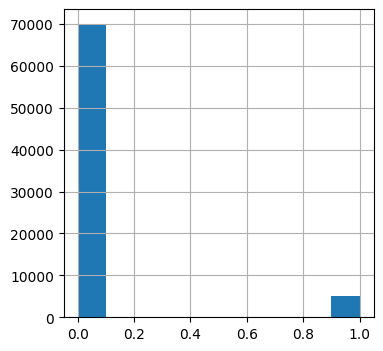

In [14]:
# Check for class imbalance

plt.figure(figsize=[4,4])
y.hist();
np.bincount(y)

We create two StandardScaler objects: one for scaling the training data and another for the test data (for which we don’t know the true labels). The test data should be scaled using the statistics from all training data.  
To obtain more reliable quality estimates on the validation data, we should scale it only based on the first 70% of the data, while using the remaining 30% as validation to evaluate our model.

In [15]:
scaler = StandardScaler()
scaler_test = StandardScaler()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=32)
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

scaler_test.fit(X)
test_df_scaled = scaler_test.transform(test_df)

As a baseline model, we will use logistic regression.

In [16]:
# Create stratified folds, since we have a strong class imbalance, and we want to take this into account
# when searching for parameters with "GridSearchCV"

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)

In [17]:
%%time
# First, try to get a logistic regression prediction on unscaled data.

logit = LogisticRegression(random_state=32, class_weight="balanced", max_iter=1000)
params = {"C":[0.001, 0.01,1,10,100]}
logit_grid = GridSearchCV(logit, param_grid=params, cv=skf)
logit_grid.fit(X_train, y_train)

CPU times: total: 26.8 s
Wall time: 22.5 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=32),
             param_grid={'C': [0.001, 0.01, 1, 10, 100]})

In [18]:
logit_auc = roc_auc_score(y_valid, logit_grid.best_estimator_.predict_proba(X_valid)[:,1])
logit_auc

0.7600204465237553

In [19]:
%%time
# Since we don’t have too much data, and the linear model runs quickly, we can test 2 identical models:
# one with scaled data, and one with raw data.

scaled_logit = LogisticRegression(random_state=32, class_weight="balanced", max_iter=1000)
params = {"C":[0.001, 0.01,1,10,100]}
scaled_logit_grid = GridSearchCV(scaled_logit, param_grid=params, cv=skf)
scaled_logit_grid.fit(X_train_scaled, y_train)

CPU times: total: 4.84 s
Wall time: 4.19 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=32),
             param_grid={'C': [0.001, 0.01, 1, 10, 100]})

We can immediately notice that the model with scaled data trains much faster, which will make our work easier in the future when we have a larger number of samples.

In [20]:
scaled_logit_auc = roc_auc_score(y_valid, scaled_logit_grid.best_estimator_.predict_proba(X_valid_scaled)[:,1])
scaled_logit_auc

0.7639389043961768

In [21]:
# We see a very small difference, so far the only advantage of scaled data is faster training.

logit_auc, scaled_logit_auc

(0.7600204465237553, 0.7639389043961768)

In [22]:
# Judging by the regularization indicators, we may have strongly correlated features.

logit_grid.best_params_, scaled_logit_grid.best_params_

({'C': 10}, {'C': 100})

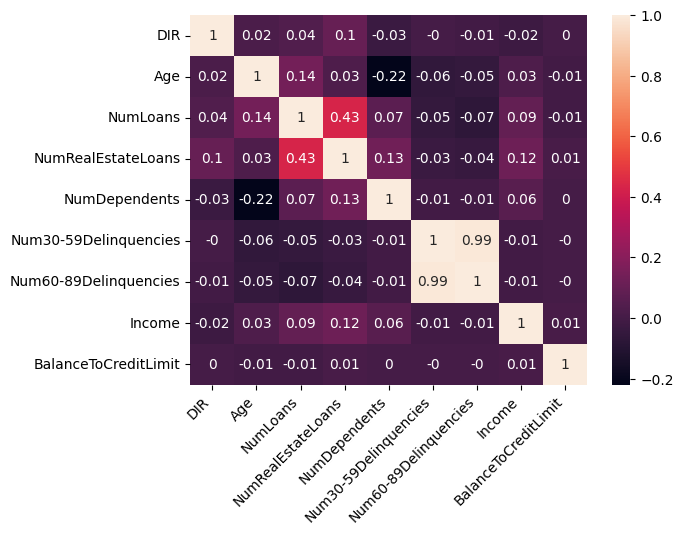

In [23]:
sns.heatmap(X_train.corr().round(2), annot=True)
plt.xticks(rotation=45, ha='right')
plt.show()

We see that two features are 99% correlated. In most cases, removing one of the features in such a situation improves the model. However, in our case, the features are most likely highly sparse, which explains such high correlation. We see that these features are:  
"Num30-59Delinquencies" – the number of credit payment delinquencies from 30 to 59 days (natural number), and  
"Num60-89Delinquencies" – the number of credit payment delinquencies from 60 to 89 days (natural number).  
Despite the high sparsity of these features, they are most likely very valuable for our target feature  
"Delinquent90" – whether there were delinquencies over 90 days (binary).  
Let’s check:

In [24]:
important_coef_X_train = pd.DataFrame(logit_grid.best_estimator_.coef_.flatten(), 
                                      index=X.columns, columns=["train_value"])
display(important_coef_X_train.abs().sort_values("train_value", ascending=False)/ important_coef_X_train.sum())


important_coef_X_train_scaled = pd.DataFrame(scaled_logit_grid.best_estimator_.coef_.flatten(), 
                                             index=X.columns, columns=["scaled_train_value"])
display(important_coef_X_train_scaled.abs().
        sort_values("scaled_train_value", ascending=False)/ important_coef_X_train_scaled.sum())

,train_value
Num30-59Delinquencies,0.816225
NumDependents,0.112373
Num60-89Delinquencies,0.053937
NumRealEstateLoans,0.051383
Age,0.028233
NumLoans,0.005652
DIR,0.000025
Income,0.000022
BalanceToCreditLimit,0.000014


,scaled_train_value
Num30-59Delinquencies,0.932124
Num60-89Delinquencies,0.320452
Age,0.168756
Income,0.095959
NumDependents,0.026633
DIR,0.022442
NumRealEstateLoans,0.020207
NumLoans,0.012578
BalanceToCreditLimit,0.000319


In [25]:
display(X["Num30-59Delinquencies"].value_counts())
X["Num60-89Delinquencies"].value_counts()

Num30-59Delinquencies
0     63012
1      8002
2      2305
3       885
4       361
5       174
98      139
6        71
7        28
8        10
9         5
10        3
12        2
13        1
11        1
96        1
Name: count, dtype: int64

Num60-89Delinquencies
0     71161
1      2888
2       568
3       160
98      139
4        56
5        16
6         7
7         3
96        1
11        1
Name: count, dtype: int64

We confirm that our hypothesis was correct, and these features should not be removed. For the logistic regression model, we need to decide whether we will work with scaled or unscaled data. In most cases, scaling the data is the better choice, but sometimes it is not. Let’s check the difference in performance again with cross-validation:

In [26]:
logit = LogisticRegression(random_state=32, class_weight="balanced", max_iter=1000, C=logit_grid.best_params_['C'])
_,_,cv_train_score = learning_curve(logit, X_train, y_train, n_jobs=-1, train_sizes=[0.99999], 
                                    cv=skf, random_state=32, scoring='roc_auc')
cv_train_score.mean()

0.772018041837906

In [27]:
scaled_logit = LogisticRegression(random_state=32, class_weight="balanced", max_iter=1000, 
                                  C=scaled_logit_grid.best_params_['C'])
_,_,cv_scaled_train_score = learning_curve(scaled_logit, X_train_scaled, y_train, 
                                 n_jobs=-1, train_sizes=[0.99999], cv=skf, random_state=32, scoring='roc_auc')
cv_scaled_train_score.mean()

0.7644712986496323

As we can see, the difference in cross-validation is also small, and the model trained on unscaled data even showed slightly better results. For the final decision, let’s build learning curves, to better understand the situation and to visualize why in most cases it is preferable to work with scaled data for linear models:

In [28]:
# Create a function that plots the learning curves.

def plot_learning_curve(estimator, X, y, ylim=None, cv=None, title_est=None,
                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 20), scoring='roc_auc'):
    plt.figure()
    plt.title("Learning Curves {}".format(title_est)) if title_est != None else plt.title("Learning Curves")
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

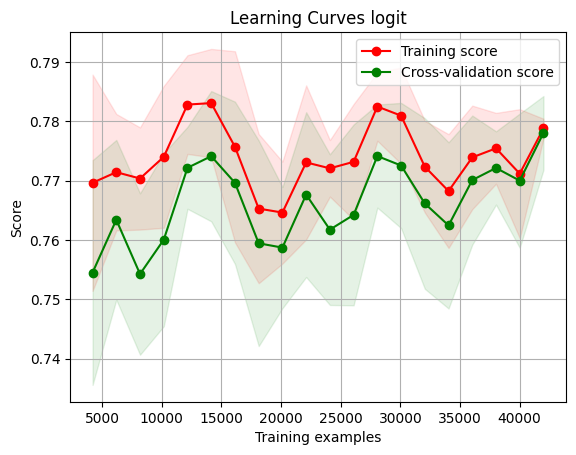

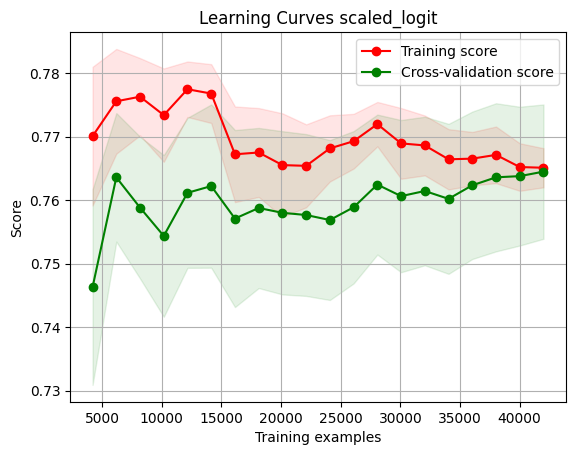

In [29]:
plot_learning_curve(logit, X_train, y_train, cv=skf, n_jobs=-1, title_est="logit");
plot_learning_curve(scaled_logit, X_train_scaled, y_train, cv=skf, n_jobs=-1, title_est="scaled_logit");

We see that with scaled features our model shows less variance, it is more stable. Also, we can immediately notice that our model is underfitting and has high bias, and adding more data will not improve it, since the learning curves converge. At this point, we either need to make the model more complex, or switch to an ensemble method (ensembles reduce bias). But logistic regression is very well interpretable through its coefficients:

In [325]:
important_coef_X_train_scaled.sort_values("scaled_train_value", ascending=False)

,scaled_train_value
Num30-59Delinquencies,2.507531
Num60-89Delinquencies,0.862057
NumDependents,0.071646
NumRealEstateLoans,0.054359
BalanceToCreditLimit,0.000859
NumLoans,-0.033838
DIR,-0.060371
Income,-0.258143
Age,-0.453975


All positive values in this table are features that, when increased, raise the probability of belonging to the first class (credit delinquencies over 90 days).
All negative values are features that, when increased, lower the probability of belonging to the first class, and the larger the absolute value, the stronger the influence of that feature.  

Now let’s try to improve the model so that on the full dataset it is neither underfitting nor too biased:

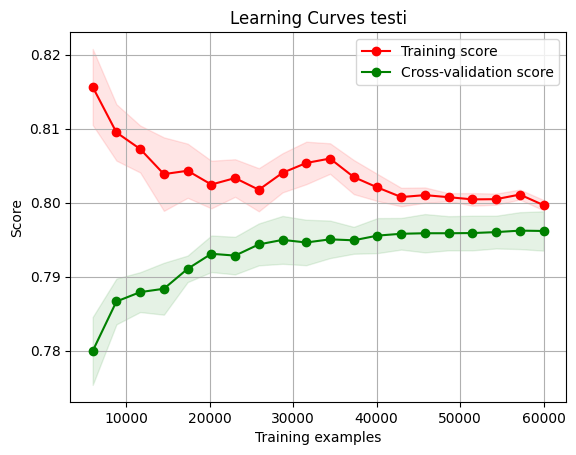

In [39]:
# Check what happens to the learning curves if we add polynomial features of degree 2.

scaler_pol = StandardScaler()
X_pol = scaler_pol.fit_transform(X)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_pol)

polynom_logit = LogisticRegression(C=100, random_state=33, class_weight="balanced", max_iter=1000)
plot_learning_curve(polynom_logit, X_poly, y, cv=skf, n_jobs=-1, title_est="polynom_logit");

In [64]:
%%time
# Search for suitable parameters for logistic regression using our X_train dataset with polynomial features.

scaler_pol_2 = StandardScaler()
X_pol_train = scaler_pol_2.fit_transform(X_train)
poly_2 = PolynomialFeatures(degree=2)
X_poly_train = poly_2.fit_transform(X_pol_train)
X_pol_valid = scaler_pol_2.fit_transform(X_valid)
X_poly_valid = poly_2.transform(X_pol_valid)

polynom_logit = LogisticRegression(C=100, random_state=33, class_weight="balanced", max_iter=1000)
params = {"C":[0.001, 0.01,1,10,100]}
polynom_logit = GridSearchCV(polynom_logit, param_grid=params, cv=skf)
polynom_logit.fit(X_poly_train, y_train)

In [50]:
polynom_logit_auc = roc_auc_score(y_valid, polynom_logit.best_estimator_.predict_proba(X_poly_valid)[:,1])
polynom_logit_auc

0.7930126888404276

As we can see, adding polynomial features of degree 2 improves our metrics, and the model now looks less biased. Moreover, adding more data will continue to steadily improve predictive performance for some time. However, as a rule, ensembles handle bias reduction better, so let’s check:

In [71]:
%%time
# First, search for suitable parameters for Random Forest with a small number of trees
# (to reduce computation time), then once we find suitable parameters, increase the number of trees.

params = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}
forest = RandomForestClassifier(random_state=32, n_estimators=30)
forest_grid = GridSearchCV(forest, param_grid=params, cv=skf)
forest_grid.fit(X_train, y_train)

CPU times: total: 10min 54s
Wall time: 11min 1s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=30, random_state=32),
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]})

In [72]:
forest_grid.best_params_

{'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 3}

In [46]:
%%time
forest = RandomForestClassifier(random_state=32, n_estimators=200, 
                                max_depth=10, max_features=4, min_samples_leaf=3)
forest.fit(X_train, y_train)

CPU times: total: 37.6 s
Wall time: 37.7 s


RandomForestClassifier(max_depth=10, max_features=4, min_samples_leaf=3,
                       n_estimators=200, random_state=32)

In [54]:
forest_auc = roc_auc_score(y_valid, forest.predict_proba(X_valid)[:,1])
forest_auc

0.8413345829803448

We improved the model, let’s now try another ensemble – XGBoost:

In [68]:
# Prepare parameters for the first "GridSearchCV" model with XGBoost.

params = {"max_depth": range(4,9), "subsample":[0.6,1], 'reg_lambda': [0.001, 0.01, 0.1, 1, 10, 100]}
xgb_sklearn_model = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", 
                                  random_state=32)
xgb_grid = GridSearchCV(xgb_sklearn_model, param_grid=params, cv=skf, n_jobs=-1)

In [70]:
%%time
xgb_grid.fit(X_train, y_train)

CPU times: total: 6.89 s
Wall time: 1min 56s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=32, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(4, 9),
                         'reg_lambda': [0.001, 0.01, 0.1, 1, 10, 100],
                         'subsample': [0.6, 1]})

In [71]:
xgb_grid.best_params_

{'max_depth': 5, 'reg_lambda': 100, 'subsample': 1}

In [72]:
xgb_grid_auc = roc_auc_score(y_valid, xgb_grid.best_estimator_.predict_proba(X_valid)[:,1])
xgb_grid_auc

0.8421031564269587

We see that XGBoost already shows better results with just 50 trees. Let’s try refining the algorithm:

In [103]:
params_2 = {'reg_lambda': [50,80,100,110, 150]}
xgb_sklearn_model_2 = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", 
                                  random_state=32, max_depth=5)
xgb_grid_2 = GridSearchCV(xgb_sklearn_model_2, param_grid=params_2, cv=skf, n_jobs=-1)

In [104]:
%%time
xgb_grid_2.fit(X_train, y_train)

CPU times: total: 1.86 s
Wall time: 7.06 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=32, ...),
             n_jobs=-1, param_grid={'reg_lambda': [50, 80, 100, 110, 150]})

In [105]:
xgb_grid_2.best_params_

{'reg_lambda': 100}

We try pruning our tree to see if it brings a positive effect:

In [57]:
params_3 = {'gamma': [0, 0.2, 1, 10, 100]}
xgb_sklearn_model_3 = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", 
                                  random_state=32, max_depth=5, reg_lambda=100)
xgb_grid_3 = GridSearchCV(xgb_sklearn_model_3, param_grid=params_3, cv=skf, n_jobs=-1)

In [58]:
%%time
xgb_grid_3.fit(X_train, y_train)

CPU times: total: 2.14 s
Wall time: 7.14 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=32, ...),
             n_jobs=-1, param_grid={'gamma': [0, 0.2, 1, 10, 100]})

In [59]:
xgb_grid_3.best_params_

{'gamma': 0}

In [41]:
eval_set = [(X_valid, y_valid)]
xgb_final = XGBClassifier(n_estimators=1000, learning_rate=0.1, objective="binary:logistic", max_depth=5,
                                        random_state=32, reg_lambda=100, early_stopping_rounds=100, eval_metric="auc")

In [43]:
%%time
xgb_final.fit(X_train, y_train, eval_set=eval_set, verbose=100)

[0]	validation_0-auc:0.79770
[100]	validation_0-auc:0.84264
[200]	validation_0-auc:0.84254
[224]	validation_0-auc:0.84235
CPU times: total: 14.4 s
Wall time: 4.03 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=32, ...)

In [44]:
xgb_final_auc = roc_auc_score(y_valid, xgb_final.predict_proba(X_valid)[:,1])
xgb_final_auc

0.8427951892052388

In [45]:
best_iteration = xgb_final.best_iteration
best_iteration

125

As we can see, Random Forest and XGBoost showed approximately the same results, but XGBoost is faster. Let’s check the results on cross-validation and on the full dataset to make a final decision:

In [37]:
%%time
forest_model_cv = RandomForestClassifier(random_state=32, n_estimators=200, 
                                max_depth=10, max_features=4, min_samples_leaf=3)
_,_,forest_cv = learning_curve(forest_model_cv, X, y, n_jobs=-1, train_sizes=[0.99999], 
                                    cv=skf, random_state=32, scoring='roc_auc')
forest_cv.mean()

CPU times: total: 141 ms
Wall time: 2min 19s


0.8459786321376267

In [40]:
%%time
xgb_final_model_cv = XGBClassifier(n_estimators=best_iteration, learning_rate=0.1, objective="binary:logistic", 
                                   max_depth=5, random_state=32, reg_lambda=100, eval_metric="auc")
_,_,xgb_final_cv = learning_curve(xgb_final_model_cv, X, y, n_jobs=-1, train_sizes=[0.99999], 
                                    cv=skf, random_state=32, scoring='roc_auc')
xgb_final_cv.mean()

CPU times: total: 141 ms
Wall time: 10.2 s


0.847871477185843

By all metrics, XGBoost performs slightly better. Let’s plot the ROC curve and learning curves to make a final decision:

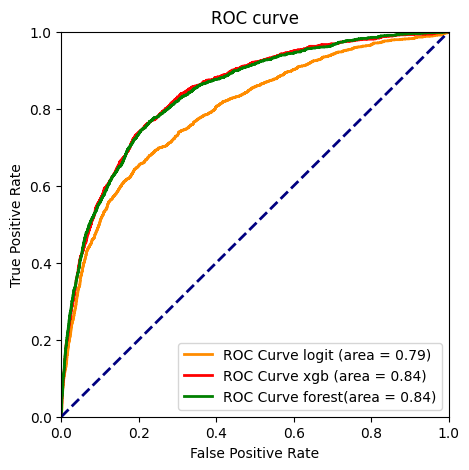

In [56]:
# Plot ROC-AUC for all our models.

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_valid, xgb_final.predict_proba(X_valid)[:,1])
fpr_for, tpr_for, thresholds_for = roc_curve(y_valid, forest.predict_proba(X_valid)[:,1])
fpr_log, tpr_log, thresholds_log = roc_curve(y_valid, polynom_logit.predict_proba(X_poly_valid)[:,1])
plt.figure(figsize=(5, 5))
plt.plot(fpr_log, tpr_log, color='darkorange', lw=2, label="ROC Curve logit (area = {:.2f})".
         format(polynom_logit_auc))
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label="ROC Curve xgb (area = {:.2f})".
         format(xgb_final_auc))
plt.plot(fpr_for, tpr_for, color='green', lw=2, label="ROC Curve forest(area = {:.2f})".
         format(forest_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc="best")
plt.show()

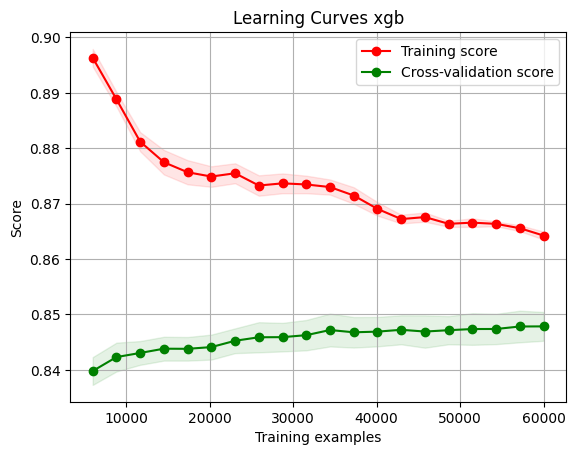

In [58]:
xgb_final_learning_curve = XGBClassifier(n_estimators=best_iteration, learning_rate=0.1, objective="binary:logistic", 
                                         max_depth=5, random_state=32, reg_lambda=100, eval_metric="auc")
plot_learning_curve(xgb_final_learning_curve, X, y, cv=skf, n_jobs=-1, title_est="xgb");

As we can see, this model suits us well. Now we train the algorithm on the full dataset to make predictions on our test set:

In [ ]:
xgb_final_predict = XGBClassifier(n_estimators=best_iteration, learning_rate=0.1, objective="binary:logistic", 
                                         max_depth=5, random_state=32, reg_lambda=100, eval_metric="auc")
xgb_final_predict.fit(X,y)
final_predict = xgb_final_predict.predict_proba(test_df)[:,1]

In [61]:
# Function to save predictions to a file.

def write_to_submission_file(predicted_labels, out_file,
                             target='Delinquent90', index_label="client_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(75000, 
                                                  predicted_labels.shape[0] + 75000),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [62]:
write_to_submission_file(final_predict, "credic_scoring_predict.csv")